In [1]:
from __future__ import absolute_import, division, print_function
import sys
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network, sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
imageio.plugins.ffmpeg.download()
print(f'Running on Tensorflow {tf.__version__} and Python {sys.version}')

Running on Tensorflow 2.4.1 and Python 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]


C:\Users\alien\AppData\Roaming\Python\Python38\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 无法在设置线程模式后对其加以更改。
  warnings.warn(str(err))


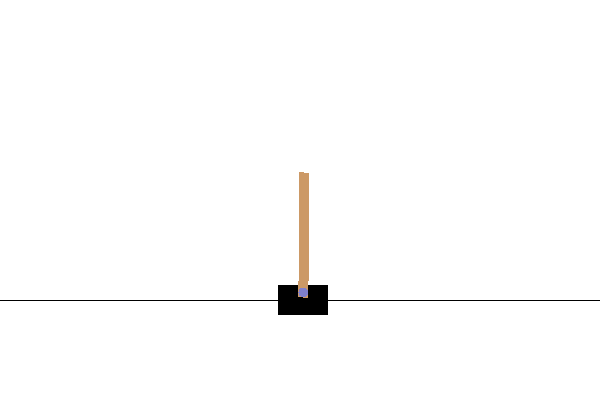

In [2]:
num_iterations = 20000
initial_collect_steps = 100
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000
batch_size = 64
learning_rate = 1e-2
log_interval = 200
num_eval_episodes = 100
eval_interval = 500
dense_layer_params = (100, 50)  # no of units for layers. Add more numbers to increase no of layers

env_name = 'CartPole-v0'
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In [3]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('\nReward Spec:')
print(env.time_step_spec().reward)
print('\nAction Spec:')
print(env.action_spec())
time_step = env.reset()
print('\nTime step:')
print(time_step)
# carpole: 0 - left, 1 - right, guess why cannot stay still? MountainCar: 0-left, 1-still, 2-right
action = np.array(0, dtype=np.int32)
next_time_step = env.step(action)
print('\nNext time step:')
print(next_time_step)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.04766495, -0.032955  ,  0.04077735, -0.02377388], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0)})

Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.04832405, -0.2286373 ,  0.04030187,  0.28149077], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1)})


In [4]:
# Two env are made, one for training one for val
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)
# Convert them to tensorflow env to run faster
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  120       
_________________________________________________________________
dense_1 (Dense)              multiple                  1200      
_________________________________________________________________
dense_2 (Dense)              multiple                  98        
Total params: 1,418
Trainable params: 1,418
Non-trainable params: 0
_________________________________________________________________
None


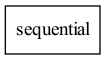

In [5]:
# DDQN Agent (Double DQN): Q-Network
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right activation and kernel initializer.
def dense_layer(num_units):
  return Dense(num_units, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer with `num_actions` units to generate one q_value per available action as it's output.
dense_layers = [dense_layer(num_units) for num_units in dense_layer_params]
q_values_layer = Dense(num_actions, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03),
                       bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])
# Network needs observation not timestep because it is not supposed to know the answer at all
# q_net = q_network.QNetwork(train_env.observation_spec(), train_env.action_spec(), fc_layer_params=dense_layer_params, activation_fn=tf.keras.activations.tanh, name='QNetwork')
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)

agent = dqn_agent.DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=opt,
    gamma=0.95,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()
print(q_net.summary())
tf.keras.utils.plot_model(q_net, 'qnet.png')

In [6]:
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

In [7]:
print(agent.collect_data_spec)
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())  # random movements
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# steps=2 here as we need both the current and future observation of the env to calculate loss
dataset = replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)
iterator = iter(dataset)
# print('Sample:', iterator.next(), sep='\n')

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0, dtype=int64), maximum=array(1, dtype=int64)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [8]:
agent.train = common.function(agent.train)  # Optimize by wrapping some of the code in a graph using TF function.
agent.train_step_counter.assign(0)  # Reset the train step

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
print('Initial return:', avg_return)

for _ in range(num_iterations):
  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, extra_info = next(iterator)
  train_loss = agent.train(experience).loss
  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print(f'step = {step}: loss = {train_loss}')

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print(f'step = {step}: Average Return over {num_eval_episodes} eps = {avg_return}')
    returns.append(avg_return)

Initial return: 29.19
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 159.10940551757812
step = 400: loss = 6.341194152832031
step = 500: Average Return over 100 eps = 9.350000381469727
step = 600: loss = 2.4527924060821533
step = 800: loss = 1.1330645084381104
step = 1000: loss = 0.4483502507209778
step = 1000: Average Return over 100 eps = 23.649999618530273
step = 1200: loss = 1.818756341934204
step = 1400: loss = 0.8733325004577637
step = 1500: Average Return over 100 eps = 87.45999908447266
step = 1600: loss = 3.4736781120300293
step = 1800: loss = 1.2506515979766846
step = 2000: loss = 2.0719587802886963
step = 2000: Average Return over 100 eps = 85.8499984741211
step = 2200: loss = 4.774064064025879
step = 2400: loss = 0.46761661767959595
step = 2500: Average Return over 100 ep

KeyboardInterrupt: 

In [ ]:
# Visualise reward, max 200 for CartPole-v0
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())
  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=20, fps=60):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

# Generate results videos of trained and random
create_policy_eval_video(agent.policy, f"{env_name} trained-agent")
create_policy_eval_video(random_policy, f"{env_name} random-agent")